# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
pd.set_option('display.max_colwidth', 999)

# Introduction
The high level purpose of this work is to help Starbucks understand how to optimize the Offers to incentivize transactions and drive higher income/profit through Offers.

There are 3 Sections:
Section 1 - Data Cleansing and Manipulation
Section 2 - Analysis
Section 3 - Recommendations

Details will follow in each individual section

# Section 1 - Data Cleansing and Manipulation
In this section we will look into the raw data, understand the shape and nature of each bit, then perform data cleansing and manipulation to arrive at the final cleaned merged dataset that will be the basis for our in depth analysis.

We start with the 3 tables above
We end up with a customer-level table, which includes the information about their 'journey' on the offer, e.g.reception viewing and completion, and will overlay that with their profile information as well as their total spending derived from the transaction table

## Section 1a: understanding the data

In [2]:
profile.head(10), profile.shape[0], profile['id'].nunique() #17000 distinct customers, no repetition in raw data

(   age  became_member_on gender                                id    income
 0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
 1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
 2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
 3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
 4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN
 5   68          20180426      M  e2127556f4f64592b11af22de27a7932   70000.0
 6  118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586       NaN
 7  118          20171002   None  68617ca6246f4fbc85e91a2a49552598       NaN
 8   65          20180209      M  389bc3fa690240e798340f5a15918d5c   53000.0
 9  118          20161122   None  8974fc5686fe429db53ddde067b88302       NaN,
 17000,
 17000)

In [14]:
transcript.groupby('event').agg('count') #next step is to split data into 4 groups according to event type

,person,time,value
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


In [2]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
 portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


# Section 1b - split the transcript into 4 different tables

We need to split the transcript data into different bits, each bit representing a stage of an offer journey.

In [3]:
offer_completed=transcript[transcript['event'].str.contains("completed")].rename(columns={'time':'time completed'})
offer_received=transcript[transcript['event'].str.contains("received")].rename(columns={'time':'time received'})
offer_viewed=transcript[transcript['event'].str.contains("viewed")].rename(columns={'time':'time viewed'})
transaction=transcript[transcript['event'].str.contains("transaction")].rename(columns={'time':'time transacted'})
offer_completed.shape[0],offer_received.shape[0],offer_viewed.shape[0],transaction.shape[0]

(33579, 76277, 57725, 138953)

In [4]:
transaction.head(5)

,event,person,time transacted,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [5]:
offer_received.head(5)

,event,person,time received,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
#we need to convert value from a dictionary-style column to a string column so that we can join back to other tables later on
offer_received['value']=[str(id).replace("{'offer id': '","").replace("'}","").strip() for id in (offer_received['value'].tolist())]
offer_received.head(5)

,event,person,time received,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [6]:
#same cleaning for offer viewed string conversion
offer_viewed['value']=[str(id).replace("{'offer id': '","").replace("'}","").strip() for id in (offer_viewed['value'].tolist())]
offer_viewed.head(5)

,event,person,time viewed,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [4]:
#let's check when are the offers received - is it all time 0
offer_received.groupby('time received').agg('count').head(5) #some people received offers later, need to consider that

,event,person,value
time received,,,
0,12650,12650,12650
168,12669,12669,12669
336,12711,12711,12711
408,12778,12778,12778
504,12704,12704,12704


In [7]:
#offer_completed is tricky - need to split the value entry into id and reward first then do the cleaning
offer_completed['value clean']=[str(id).replace("'",'"')  for id in (offer_completed['value'])]
offer_completed.reset_index(drop=True, inplace=True)
offer_completed.head(5)

,event,person,time completed,value,value clean
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,"{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}","{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}"
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,"{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}","{""offer_id"": ""fafdcd668e3743c1bb461111dcafc2a4"", ""reward"": 2}"
2,offer completed,629fc02d56414d91bca360decdfa9288,0,"{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}","{""offer_id"": ""9b98b8c7a33c4b65b9aebfe6a799e6d9"", ""reward"": 5}"
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,"{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}","{""offer_id"": ""ae264e3637204a6fb9bb56bc8210ddfd"", ""reward"": 10}"
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,"{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}","{""offer_id"": ""4d5c57ea9a6940dd891ad53e9dbe8da0"", ""reward"": 10}"


In [8]:
#data manipulation for offer_completed dataset continued
dfcompleted=pd.DataFrame(json.dumps(id) for id in (offer_completed['value']))
dfcompleted[['offer_id','reward']] = dfcompleted[0].str.split(',', expand=True)
dfcompleted['offer_id']=[str(id).replace('{"offer_id":', "").replace('"','').strip() for id in (dfcompleted['offer_id'].tolist())]
dfcompleted['reward']=[str(id)[10:].replace('}','').strip() for id in (dfcompleted['reward'].tolist())]
offer_complete_clean=pd.concat([offer_completed, dfcompleted], axis=1)
offer_complete_clean=offer_complete_clean.drop(columns=['value', 0])
offer_complete_clean
#good, exactly what we want to see

,event,person,time completed,value clean,offer_id,reward
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,"{""offer_id"": ""fafdcd668e3743c1bb461111dcafc2a4"", ""reward"": 2}",fafdcd668e3743c1bb461111dcafc2a4,2
2,offer completed,629fc02d56414d91bca360decdfa9288,0,"{""offer_id"": ""9b98b8c7a33c4b65b9aebfe6a799e6d9"", ""reward"": 5}",9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,"{""offer_id"": ""ae264e3637204a6fb9bb56bc8210ddfd"", ""reward"": 10}",ae264e3637204a6fb9bb56bc8210ddfd,10
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,"{""offer_id"": ""4d5c57ea9a6940dd891ad53e9dbe8da0"", ""reward"": 10}",4d5c57ea9a6940dd891ad53e9dbe8da0,10
5,offer completed,227f2d69e46a4899b70d48182822cff6,0,"{""offer_id"": ""4d5c57ea9a6940dd891ad53e9dbe8da0"", ""reward"": 10}",4d5c57ea9a6940dd891ad53e9dbe8da0,10
6,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,"{""offer_id"": ""2298d6c36e964ae4a3e7e9706d1fb8c2"", ""reward"": 3}",2298d6c36e964ae4a3e7e9706d1fb8c2,3
7,offer completed,d72d201be5794279aa716d8ad82b8d90,0,"{""offer_id"": ""f19421c1d4aa40978ebb69ca19b0e20d"", ""reward"": 5}",f19421c1d4aa40978ebb69ca19b0e20d,5
8,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2
9,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,"{""offer_id"": ""4d5c57ea9a6940dd891ad53e9dbe8da0"", ""reward"": 10}",4d5c57ea9a6940dd891ad53e9dbe8da0,10


# important - review of duplication
the same customer might receive, view, and complete the same offer multiple times at different points, or same customer different offers - we need to take all of these into consideration before we join everything together

In [6]:
offer_received['person'].nunique(),offer_received.shape[0],offer_received[['person', 'time received']].nunique()# 16994 distinct customers received 76277 offers

(16994, 76277, person           16994
 time received        6
 dtype: int64)

In [43]:
receiver_profile=offer_received.merge(profile, how='inner', left_on='person', right_on='id')
receiver_profile['person'].nunique() #for every customer who received an offer, we have their info in Profile

16994

In [48]:
unique_person_offer=offer_received.drop_duplicates(subset=['person', 'value','time received'], keep='first')
unique_person_offer.shape[0]
person_offer=pd.DataFrame(offer_received.groupby('person').agg('count')['value'])
person_offer.sort_values(by='value', ascending=False)
person_offer.agg('average') #16994 customers received 76277 offers, on average every customer received 4.48 offers

array([ 4.48846652])

In [71]:
unique_person_offer=offer_received.drop_duplicates(subset=['person', 'value'], keep='first')
unique_person_offer.shape[0] #76277 total offers, 63288 unique customer-offer pairs, some offers are given to the same customer multiple times at different point

63288

In [49]:
unique_person_completion=offer_complete_clean.drop_duplicates(subset=['person', 'offer_id', 'time completed'], keep='first')
offer_complete_clean.shape[0],unique_person_completion.shape[0] #33579 completed offers, 33182 unique person-offerid-time pairs
#this means that some customers completed the same offer at the same points. 
#These are few in number, we'll ignore those as there are no ways to tell the duplicated ones apart

(33579, 33182)

In [50]:
unique_person_completion=offer_complete_clean.drop_duplicates(subset=['person', 'offer_id',], keep='first')
offer_complete_clean.shape[0],unique_person_completion.shape[0] #33579 completed offers, 28996 unique person-offerid pairs
#this means that some customers completed the same offer at the same points. 
#we don't have to dedup these - same offer same customer different completion time are distinctively identifiable through time

(33579, 28996)

In [52]:
unique_person_view=offer_viewed.drop_duplicates(subset=['person', 'value', 'time viewed'], keep='first')
offer_viewed.shape[0],unique_person_view.shape[0] #57725 viewed offers, 57725 unique person-offerid-time pairs
#no dups

(57725, 57725)

In [53]:
unique_person_view=offer_viewed.drop_duplicates(subset=['person', 'value'], keep='first')
offer_viewed.shape[0],unique_person_view.shape[0] #57725 viewed offers, 49135 unique person-offerid pairs
#this means same customer viewed the same offer id at different times, which will result in duplication
#this will be dealt with later

(57725, 49135)

# Section 1c: Data Manipulation - joining tables together

In this section we will join different bits together to form a 'journey' view of each offer-customer pair. We'll aim to identify 'successful journey' where the offer was received first, then viewed, then completed. Also we will restrict the successful journeys with consideration of the 'duration' window, i.e. if an offer is completed beyond the duration of the offer, it's not a successful journey.

Only successful journeys are driven by the Offer - these are the journeys we want more. The unsuccessful journeys include offers that aren't viewed, aren't completed, or are completed accidentally without viewing. All of the unsuccessful journeys can be summarized as a 'wasted' offer - the offer itself did not drive the transactions.

In terms of order, we will start with the end of the journey, which is completion, then work backwards towards View, clean/dedup, and then back to Reception, again, clean/dedup. This will give us a clean, complete 'journey' dataset that includes only and all of the successful journeys.

The most important bit here is the consideration of duplication and how we deal with it. The same customer can complete and/or receive the same offer multiple times at different points in time. The best approach here is not to dedup indiscriminantly but to consider individual journeys separately where possible. For example, a customer who has been offered 4 BOGO offers and completed all 4 BOGO offers, is different from a customer who was offered 4 BOGO offers and completed 1 BOGO offer, who is also different from a customer who has been offered a BOGO offer once and completed it once, who is different from a customer who has been offered a BOGO offer at some point but didn't complete at all.

The next bit is to derive the customer level view. At the end of the day we are trying to identify which customers to give what offer, so the customer level view is essential. We will classify the entire customer base into 'good' and 'bad' customers - 'good' being the customer completed at least one offer journey successfully.

Ultimate output of this section are 2 datasets:

1. Successful Journey dataset, dfjourney: this should have 3 columns: person, offer_id, and the number of successful journey completed for the person-offer pair. Using this dataset we can pull back all the offer and customer information from Profile and Portfolio tables
2. Customer dataset that includes the good/bad customer flag, dfcust: this should have 3 columns: person, the total number of successful journeys they have completed, and whether they have completed at least 1 journey.

# ***The most complicated bit of logic - definition and identification of 'successful journeys'***

This is the trickest bit of the whole logic. Not all completed offers are 'successful' - some of them are completed accidentally and not driven by the offer itself.

For a completion to be successful:

1. Completion has to be done after viewing. This means if the completion was done before viewing, or without viewing, it's not successful.
2. Completion-reception gap has to be within the Duration of the offer

In [9]:
#for each completed offer, let's join back to the viewed dataset to understand whether the offer was viewed before completion
#the join conditions we use is to match on person and offer id, we will deal with duplicates right after this
complete_view=offer_complete_clean.merge(offer_viewed,how='inner',left_on=['person','offer_id'], right_on=['person','value'])
#for a journey to be logical, the offer has to be completed after being viewed - therefore we need a non-negative time gap
complete_view['gap view completion']=complete_view['time completed']-complete_view['time viewed']
complete_view_logical=complete_view.loc[complete_view['gap view completion']>= 0].drop_duplicates()
complete_view_logical=complete_view_logical.merge(portfolio,how='inner',left_on=['offer_id'], right_on=['id'])
complete_view_logical #there are 28578 completed offers which have been viewed prior to completion
#for the clean logic, it's not going to be perfect at this point, but let's apply the 'duration' method
#i.e. the view-completion time gap cannot exceed duration of the offer
complete_view_logical['duration']=complete_view_logical['duration']*24 #convert days to hours
#the time gap between viewed and completed has to be within the duration
complete_view_logical['duration check']=complete_view_logical['duration']-complete_view_logical['gap view completion']
complete_view_logical_final=complete_view_logical.loc[complete_view_logical['duration check']>=0]
complete_view_logical_final


,event_x,person,time completed,value clean,offer_id,reward_x,event_y,time viewed,value,gap view completion,channels,difficulty,duration,id,offer_type,reward_y,duration check
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,168
1,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,168
4,offer completed,a45b69f1c8554ae7af83e74426ca437a,480,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,312,2906b810c7d4411798c6938adc9daaa5,168,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,0
5,offer completed,645bdee43b0f43899320fcb0b427084c,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,168
6,offer completed,686337f3cd1d4f548af8dcf79b727954,432,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,408,2906b810c7d4411798c6938adc9daaa5,24,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,144
7,offer completed,41486bbaab7a49e2afc05d2b48d3b00f,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,168
9,offer completed,41486bbaab7a49e2afc05d2b48d3b00f,372,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,354,2906b810c7d4411798c6938adc9daaa5,18,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,150
10,offer completed,4e755b41845349b4bc3c2ae60902ee13,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,168
12,offer completed,4e755b41845349b4bc3c2ae60902ee13,582,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,516,2906b810c7d4411798c6938adc9daaa5,66,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,102
13,offer completed,aa8159bbe9134ccfb6d7807714c8ea19,0,"{""offer_id"": ""2906b810c7d4411798c6938adc9daaa5"", ""reward"": 2}",2906b810c7d4411798c6938adc9daaa5,2,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,168


In [10]:
unique_view_completion=complete_view_logical.drop_duplicates(subset=['person', 'offer_id','time completed'], keep='first')
complete_view_logical.shape[0],unique_view_completion.shape[0]
#this is very important - we have 28578 completed offers which have been viewed prior to completion, 
#but some customers viewed the same offer multiple times at different points in time,as we have identified earlier, therefore there are duplicates

(28578, 24614)

In [78]:
unique_view_completion=complete_view_logical_final.drop_duplicates(subset=['person', 'offer_id','time completed'], keep='first')
complete_view_logical_final.shape[0],unique_view_completion.shape[0]
#23840 appears to be the totoal number of successful journeys

(24739, 23840)

In [11]:
#let's perform a final cleaning - keeping only the relevant columns we need now, also dedup on time completed
#the same offer, same person, completed on the same time, cannot be distinguished - therefore we will dedup these
#it is important to bear in mind that our starting point is the offer_completed dataset
#in the strictist sense, we don't care how many times an offer is viewed before completion
#we put in the view-completion overlay to filter off the illogical completion, i.e. offers completed before or without viewing
complete_view_logical_final=complete_view_logical_final[['person', 'time completed','offer_id']].drop_duplicates()
complete_view_logical_final.head(5), complete_view_logical_final.shape[0]
#we have 23840 unique completed offers that are completed after viewing
#to reiterate, these offers have been viewed at least once before being completed and the view-complete gap is within the duration

(                             person  time completed  \
 0  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f               0   
 1  73ffefd41e9a4ca3ab26b2b3697c6eb7               0   
 4  a45b69f1c8554ae7af83e74426ca437a             480   
 5  645bdee43b0f43899320fcb0b427084c               0   
 6  686337f3cd1d4f548af8dcf79b727954             432   
 
                            offer_id  
 0  2906b810c7d4411798c6938adc9daaa5  
 1  2906b810c7d4411798c6938adc9daaa5  
 4  2906b810c7d4411798c6938adc9daaa5  
 5  2906b810c7d4411798c6938adc9daaa5  
 6  2906b810c7d4411798c6938adc9daaa5  , 23840)

In [13]:
#now let's do the same thing for the earlier dataset, offer_received
#this time we would like to filter off offers that are completed beyond the duration window
#duration = max time gap between reception and completion
#if the time gap exceeds duartion, we'll filter these completion off
complete_view_receive=complete_view_logical_final.merge(offer_received,how='inner',left_on=['person','offer_id'], right_on=['person','value'])
complete_view_receive=complete_view_receive.merge(portfolio,how='inner',left_on=['offer_id'], right_on=['id'])
complete_view_receive['duration']=complete_view_receive['duration']*24
complete_view_receive['gap receive completion']=complete_view_receive['time completed']-complete_view_receive['time received']
complete_view_receive['duration check']=complete_view_receive['duration']-complete_view_receive['gap receive completion']
#similar to before, a logical completion is a completion done after reception and within the duration
complete_view_receive_logical=complete_view_receive.loc[complete_view_receive['gap receive completion']>=0].loc[complete_view_receive['duration check']>=0]
complete_view_receive_logical.shape[0]

25052

In [14]:
#again let's clean up and dedup
complete_view_receive_final=complete_view_receive_logical[['person', 'time completed', 'offer_id']].drop_duplicates()
complete_view_receive_final.shape[0], complete_view_receive_final['person'].nunique()
#very good! same as the number earlier after our view-complete cleansing
#this means any offer that has been completed after being viewed were completed within the proper duration as well
#this is preparation for our final 'successful journeys' datasets
#we have 23840 successful journeys, let's have a look at what these journeys are like and who made those successful journeys

(23840, 11651)

# Important number: 23840 is the total number of successful journeys that are logically completed

for every bit that follows, we should make sure the total number of successful journeys in each table match back to 23840. This will be an important check besides 76277 (total number of received offers) and 16994 (total number of distinct customers who received an offer).

We can depart from the offer_completed and offer_viewed datasets now.

In [15]:
#now it's time to shape up the final journey dataset
#we will start by looking at successful journeys, putting them into one table, then combine with the overall received offers
dfsuccess=pd.DataFrame(complete_view_receive_final.groupby(['person', 'offer_id'])['time completed'].count()).reset_index().rename(columns={'time completed':'number of successful journeys'})
dfsuccess.head(5)
#excellent, spot on the shape we would like to see

,person,offer_id,number of successful journeys
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1


In [43]:
dfsuccess['number of successful journeys'].sum()
#excellent, spot on

23840

In [16]:
#let's do something similar to the offer_received dataset
dfreceived=pd.DataFrame(offer_received.groupby(['person', 'value'])['time received'].count()).reset_index().rename(columns={'time received':'number of offers given'})
dfreceived.head(5)
#excellent, spot on the shape we would like to see

,person,value,number of offers given
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


In [45]:
dfreceived['number of offers given'].sum()
#excellent, spot on

76277

In [18]:
#now let's combine dfsuccess with dfreceived to derive our journey final dataset dfjourney
#this dataset will provide a complete picture of each journey
dfjourney=dfreceived.merge(dfsuccess, how='outer', left_on=['person', 'value'], right_on=['person', 'offer_id']).drop(columns=['offer_id']).rename(columns={'value':'offer_id'})
dfjourney['number of successful journeys']= pd.to_numeric(dfjourney['number of successful journeys'].fillna(0), downcast='integer')
dfjourney=dfjourney.merge(portfolio, how='inner', left_on='offer_id', right_on='id').drop(columns=['id'])
dfjourney=dfjourney.merge(profile, how='inner', left_on='person', right_on='id').drop(columns=['id'])
dfjourney['became_member_on'] = pd.to_datetime(dfjourney['became_member_on'], format='%Y%m%d')
dfjourney['cutoff date']= '20201201' #let's use this date as a cutoff date to calculate tenure
dfjourney['cutoff date']=pd.to_datetime(dfjourney['cutoff date'], format='%Y%m%d')
dfjourney['cutoff date']
dfjourney['tenure']=pd.to_numeric((dfjourney['cutoff date']-dfjourney['became_member_on']).dt.days, downcast='integer')
dfjourney['gender']=dfjourney['gender'].replace("M", "1").replace("F", "0")
dfjourney=dfjourney.drop(columns=['became_member_on', 'cutoff date'])
dfjourney.head(5)
#excellent, exactly what we want to see

,person,offer_id,number of offers given,number of successful journeys,channels,difficulty,duration,offer_type,reward,age,gender,income,tenure
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,"[web, email, mobile]",10,7,discount,2,33,1,72000.0,1320
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,"[web, email, mobile]",0,4,informational,0,33,1,72000.0,1320
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,"[email, mobile, social]",0,3,informational,0,33,1,72000.0,1320
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0,"[web, email, mobile, social]",5,5,bogo,5,33,1,72000.0,1320
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0,"[web, email, mobile, social]",10,10,discount,2,33,1,72000.0,1320


In [19]:
#let's check
dfjourney['number of successful journeys'].sum(),dfjourney['number of offers given'].sum()
#perfect, spot on

(23840, 76277)

# Very good! now we have our first final dataset dfjourney

To reiterate what we have done to arrive at this dataset:

1. We started from the offers completed dataset backwards to offers viewed and offers received, using the logical condition that an offer has to be completed after being viewed (time gap condition is equal or more than 0), as well as the constraint that the completion should not be done beyond the duration of the offer
2. Using the above cleasning we arrived at the number 23840 successful journeys out of the 33579 offers completed in the raw data. This does not involve any deduplication*.
3. We then summarized the journey views into person-offer_id pair, because the same customer can complete the same offer multiple times at different points in time
4. Similarly we did the same summarization for 76277 offers received
5. we then joined to the profile table and the portfolio table to pull back all the relevant information we have on our customers and offers, plus some calculation such as tenure

Now we have the first final dataset dfjourney!

* the only deduplication we did was to not consider the same customer completing the same offer at the same time - this is most likely a system error. E.g. a customer completing 2 identical BOGO offers at the same time is most likely not possible in real life and isn't reflective of how the offer should work.

# Next, let's move on to customer level dataset, dfcust

In [20]:
#we have left the transaction dataset till now, let's work on it
#let's first sum the transaction value up so that we know the total expenditure of each customer
#to be honest, in this analysis we won't look too much into transaction in detail
#we base our analysis primarily on successful journey, but would like to have total expenditure as an indication of our valueable the customer is
transaction['value']=[float (str(id).replace("{'amount': ","").replace("}","")) for id in (transaction['value'].tolist())]
transaction.head(5)
transaction_total=pd.DataFrame(transaction.groupby('person').agg('sum')['value']).reset_index().rename(columns={'value':'total expenditure'})
transaction_total.head(5),transaction_total.shape[0]

(                             person  total expenditure
 0  0009655768c64bdeb2e877511632db8f             127.60
 1  00116118485d4dfda04fdbaba9a87b5c               4.09
 2  0011e0d4e6b944f998e987f904e8c1e5              79.46
 3  0020c2b971eb4e9188eac86d93036a77             196.86
 4  0020ccbbb6d84e358d3414a3ff76cffd             154.05, 16578)

In [18]:
#let's do some checks
received_customer=pd.DataFrame(offer_received[['person']].drop_duplicates())
common_customers=transaction_total.merge(received_customer, how='inner', left_on='person', right_on='person')
common_customers.shape[0]

16572

In [44]:
transaction_customers=transaction_total.merge(profile, how='inner', left_on='person', right_on='id')
transaction_customers.shape[0] #majority of customers who made a transaction make up the profile table

16578

# Review of customer numbers
let's do a review of customer numbers before we proceed
1. From the profile table we have 17000 distinct customers
2. From the offer_received table we have 16994 distinct customers - so 16994 customers received at least 1 offer, and for every one of them we have their info in Profile (checked when we performed an inner join)
3. From the transaction table we have 16578 distinct customers
4. there are 16572 customers who both received an offer and made at least 1 transaction
5. from the successful journey table complete_view_receive_final, there are 11651 distinct customers who completed 1 or more successful journeys

From the 5 points above we can conclude that the customer population we are looking at are largely those we received an offer and made at least one transaction.

We are not looking beyond this - meaning for example, the customer base which transacted a lot without receiving an offer will not be considered in our analyses simply because we don't have that bit of data - this will limit the scope of our analysis to a certain extent.

In [21]:
#let's build the customer level dataset dfcust
dfreceived=pd.DataFrame(offer_received.groupby(['person'])['time received'].count()).reset_index()
dfcompleted=pd.DataFrame(complete_view_receive_final.groupby(['person'])['time completed'].count()).reset_index()

In [22]:
dfcust=dfreceived.merge(dfcompleted, how='outer', left_on='person', right_on='person').rename(columns={'time received':'number of offers received', 'time completed': 'number of offers completed'})
dfcust['number of offers completed']= pd.to_numeric(dfcust['number of offers completed'].fillna(0), downcast='integer')
dfcust=dfcust.merge(profile, how='inner', left_on='person', right_on='id').drop(columns=['id'])
dfcust['became_member_on'] = pd.to_datetime(dfcust['became_member_on'], format='%Y%m%d')
dfcust['cutoff date']= '20201201' #let's use this date as a cutoff date to calculate tenure
dfcust['cutoff date']=pd.to_datetime(dfcust['cutoff date'], format='%Y%m%d')
dfcust['tenure']=pd.to_numeric((dfcust['cutoff date']-dfcust['became_member_on']).dt.days, downcast='integer')
dfcust['gender']=dfcust['gender'].replace("M", "1").replace("F", "0").replace("O", "0")
dfcust=dfcust.drop(columns=['became_member_on', 'cutoff date'])
dfcust=dfcust.merge(transaction_total, how='left', left_on='person', right_on='person')
dfcust.head(5)
#what we have here is a complete picture of 16994 distinct customers, of whom we have the full demographic information
#and we know whether they have successfully completed at least 1 offer journey
#and we know their total transaction
#now we can perform some analysis

,person,number of offers received,number of offers completed,age,gender,income,tenure,total expenditure
0,0009655768c64bdeb2e877511632db8f,5,0,33,1,72000.0,1320,127.60
1,00116118485d4dfda04fdbaba9a87b5c,2,0,118,None,NaN,951,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,40,0,57000.0,1057,79.46
3,0020c2b971eb4e9188eac86d93036a77,5,2,59,0,90000.0,1733,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,4,3,24,0,60000.0,1481,154.05


In [20]:
dfcust['number of offers received'].sum(),dfcust['number of offers completed'].sum(), dfcust.shape[0]

(76277, 23840, 16994)

# Hooray! now we have our second final dataset, dfcust

To recap what we have done here:

1. We looked the the 23840 successful journeys as well as the 76277 offers received and summarized them into customer level, i.e. how many journeys have each customer completed successfully and how many offers were received by each customer
2. We then pulled in all of the metrics we have from Profile table

The final dataset includes all 16994 customers who at least received one offer. This dataset includes all offers received 76277 as well as all successful journeys completed 23840.

# Section Summary

We now have 2 final datasets, dfjourney and dfcust

For both datasets we tied back to the starting point - 76277 offers received and 16994 customers who received some offers.

We also know the 'good' bits, which is successful journeys and successful customers.

We are ready to move on to Secion 2 - analysis.

# Section 2: Analysis

In this section we'll perform analyses on the previously prepared dataset

Key questions we are looking to answer:

who completes successful journeys?
which journeys are more likely successfully completed by whom?
what are their demographics? compared to the unsuccsseful journey makers?
also, who have been given an offer? are those who received an offer the right recipeient of offers? especially those who were given an offer but failed to successfully complete?

# Section 2a: customer analysis

Let's first examine the dfcust to obtain some customer level insights.

In Section 2b we'll move on to offer analysis where we examine the performance of 10 of the offers in Portfolio.

In [24]:
#let's check the percentage of missing values and decide whether we should impute
dfcust.isnull().sum()
#not a great deal missing, also the missing bits are hard to impute, what to put as gender?

person                           0
number of offers received        0
number of offers completed       0
age                              0
gender                        2174
income                        2174
tenure                           0
total expenditure              422
dtype: int64

# Important - percentage completed, our 'success' measuring metric

let's introduce a column - percentage completed.
this is calculated as numbers of offers completed/number of offers received for each person.
this is an important metric because it takes into the multiplicity of offers completed/received and therefore can help us understand the true performance of a customer, not just as a binary 1/0 flag, but acutually a continuous percentage.

We want to help starbucks achieve a high overall percentage competed for all its customers.

In [25]:
#let's introduce a column - percentage completed
#this is calculated as numbers of offers completed/number of offers received for each person
#this is an important metric because it takes into the multiplicity of offers completed/received and therefore can help us understand the true performance of a customer
dfcust['percentage completed']=dfcust['number of offers completed']/dfcust['number of offers received']
dfcust.head(5)

,person,number of offers received,number of offers completed,age,gender,income,tenure,total expenditure,percentage completed
0,0009655768c64bdeb2e877511632db8f,5,0,33,1,72000.0,1320,127.60,0.00
1,00116118485d4dfda04fdbaba9a87b5c,2,0,118,None,NaN,951,4.09,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,40,0,57000.0,1057,79.46,0.60
3,0020c2b971eb4e9188eac86d93036a77,5,2,59,0,90000.0,1733,196.86,0.40
4,0020ccbbb6d84e358d3414a3ff76cffd,4,3,24,0,60000.0,1481,154.05,0.75


In [31]:
#let's check the average percentage completed
dfcust['percentage completed'].agg('average')
#on average, each customer completes about 30% or 1 out of every 3 offers they have been given

0.31399905849123216

# Headline number 1: 31%

On average, each customer completes 31%, or 1 out of every 3 offers they have been given. This is an important number and will be of relevance to Starbucks. At the current situation, 2 out of every 3 offers are 'wasted', at customer level.

# Revisit our objective

We would like to see a higher 'utilization' rate of offers, i.e. a higher percentage completed metric for the entire population who received an offer.

To achieve this, we want more customers whose percentage is above the current average. Therefore let's perform some comparison between above and below groups to understand the differences we can leverage in temrs of their characteristics to drive higher completion rate.

In [26]:
# let's split the dfcust into 2 subsets: 1 where percentage is above average, 1 below
dfcustabove=dfcust[dfcust['percentage completed']>0.31]
dfcustbelow=dfcust[dfcust['percentage completed']<=0.31]
dfcustabove.shape[0],dfcustbelow.shape[0]
#good, total 16994

(8188, 8806)

# Headline number 2: total expenditure is £161 for Above Average, £51 for Below, £104 for Overall 

Overall, each customer in the dataset spends £104 with Starbucks on average. When we split the overall customer into 2 groups, one above and one below the average percentage completed, the differential in expenditure is obvious (£161 vs £51).

Takeaway from this is we should prioritize customers who spend more for more offers, compared to customers who spend less.

Caveat is there is a chicken-and-egg situation here - is the offer driving more transaction, or is more transactions themselves driving a higher completion percentage? Even with this in mind, there is a solid correlation (albeit not clear causality) between total expenditure and successful completion rate, which Starbucks should consider.

In [40]:
#let's do some initial comparison of the 2 groups
dfcustabove['total expenditure'].agg('average'),dfcustbelow['total expenditure'].fillna(0).agg('average'), dfcust['total expenditure'].fillna(0).agg('average')

(160.97594284318515, 51.911235521235518, 104.46047781569966)

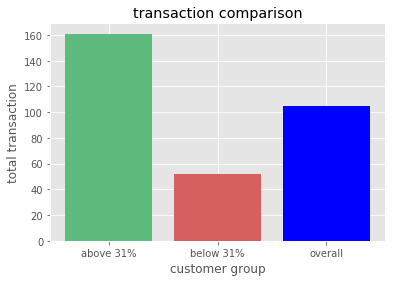

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['above 31%', 'below 31%', 'overall' ]
table= [dfcustabove['total expenditure'].agg('average'), dfcustbelow['total expenditure'].fillna(0).agg('average'),dfcust['total expenditure'].fillna(0).agg('average')]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, table, color=['#5fba7d','#d65f5f', 'blue'])
plt.xlabel("customer group")
plt.ylabel("total transaction")
plt.title("transaction comparison")

plt.xticks(x_pos, x)

plt.show()

In [45]:
#income - dropping all null values because imputation might distor the picture
dfcustabove['income'].dropna().agg('average'),dfcustbelow['income'].dropna().agg('average'), dfcust['income'].dropna().agg('average')

(68992.433795712481, 61280.116110304793, 65406.882591093119)

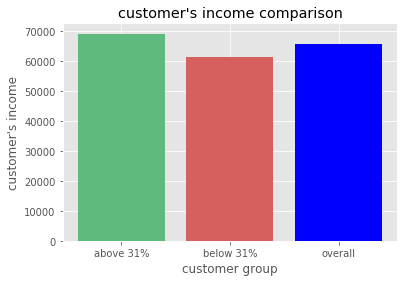

In [39]:
#let's add in some visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['above 31%', 'below 31%', 'overall' ]
table= [dfcustabove['income'].dropna().agg('average'), dfcustbelow['income'].dropna().agg('average'),dfcust['income'].dropna().agg('average')]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, table, color=['#5fba7d','#d65f5f', 'blue'])
plt.xlabel("customer group")
plt.ylabel("customer's income")
plt.title("customer's income comparison")

plt.xticks(x_pos, x)

plt.show()


In [46]:
#tenure - all customers have tenure
dfcustabove['tenure'].agg('average'),dfcustbelow['tenure'].agg('average'), dfcust['tenure'].agg('average')

(1468.2852955544699, 1291.0436066318418, 1376.4416853006944)

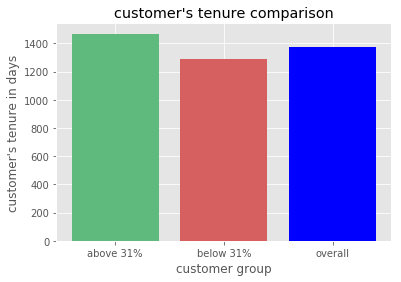

In [38]:
#let's add in some visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['above 31%', 'below 31%', 'overall' ]
table= [dfcustabove['tenure'].agg('average'), dfcustbelow['tenure'].agg('average'),dfcust['tenure'].agg('average')]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, table, color=['#5fba7d','#d65f5f', 'blue'])
plt.xlabel("customer group")
plt.ylabel("customer's tenure in days")
plt.title("customer's tenure comparison")

plt.xticks(x_pos, x)

plt.show()

# Headline 3: target younger customers who have higher income and longer membership tenure

The above comparisons tell us that above average customers have slightly higher income, longer tenure, and slightly younger age. The differences aren't massive though.

Gender doesnt seem to play a role. Male-Female split across appears to be around 50% which is what we expect in a ethical situation.

In [47]:
#age
dfcustabove['age'].dropna().agg('average'),dfcustbelow['age'].dropna().agg('average'), dfcust['age'].dropna().agg('average')

(57.691133365901322, 67.022825346354765, 62.526656466988349)

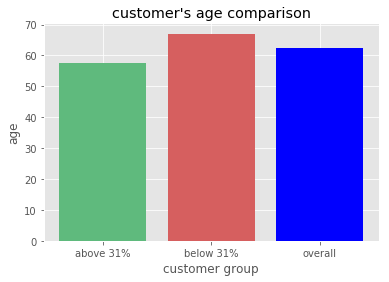

In [37]:
#let's add in some visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['above 31%', 'below 31%', 'overall' ]
table= [dfcustabove['age'].dropna().agg('average'), dfcustbelow['age'].dropna().agg('average'),dfcust['age'].dropna().agg('average')]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, table, color=['#5fba7d','#d65f5f', 'blue'])
plt.xlabel("customer group")
plt.ylabel("age")
plt.title("customer's age comparison")

plt.xticks(x_pos, x)

plt.show()

In [53]:
#gender
pd.to_numeric(dfcustabove['gender']).sum()/dfcustabove.shape[0],pd.to_numeric(dfcustbelow['gender']).sum()/dfcustbelow.shape[0], pd.to_numeric(dfcust['gender']).sum()/dfcust.shape[0]

(0.49487054225696142, 0.50317965023847377, 0.49917617982817464)

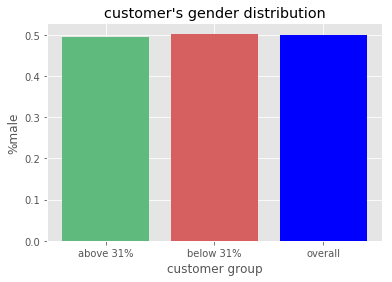

In [36]:
#let's add in some visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['above 31%', 'below 31%', 'overall' ]
table= [pd.to_numeric(dfcustabove['gender']).sum()/dfcustabove.shape[0], pd.to_numeric(dfcustbelow['gender']).sum()/dfcustbelow.shape[0],pd.to_numeric(dfcust['gender']).sum()/dfcust.shape[0]]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, table, color=['#5fba7d','#d65f5f', 'blue'])
plt.xlabel("customer group")
plt.ylabel("%male")
plt.title("customer's gender distribution")

plt.xticks(x_pos, x)

plt.show()

# Hypothesis: whether a customer completes his profile information actually has an impact on his percentage completd.

Based on preliminary inspection of the data, we have a hypothesis that if the income/age/gender columns are missing inputs from the customer, the likelihood for offer completion is lower.

Let's test this out.

In [41]:
#let's split the dfcust into 2 subsets - one where all columns are populated, one where at least 1 column is missing
is_NaN = dfcust.isnull()
row_has_NaN = is_NaN.any(axis=1) #any here
dfcustnull = dfcust[row_has_NaN]

not_NaN = dfcust.notnull()
row_not_NaN = not_NaN.all(axis=1) #all here
dfcustnotnull = dfcust[row_not_NaN]

dfcustnull.shape[0],dfcustnotnull.shape[0]
#good, total 16994

(2507, 14487)

In [54]:
#let's check average
"{:.0%}".format(dfcustnull['percentage completed'].agg('average')),"{:.0%}".format(dfcustnotnull['percentage completed'].agg('average')), "{:.0%}".format(dfcust['percentage completed'].agg('average'))
#very significant difference

('8%', '35%', '31%')

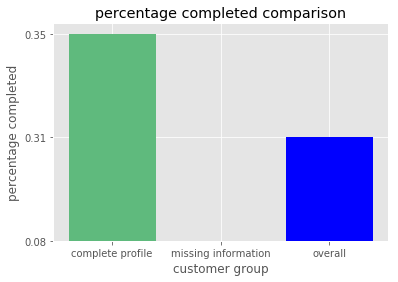

In [59]:
#let's add in some visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['complete profile', 'missing information', 'overall' ]
table= ['0.35','0.08', '0.31']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, table, color=['#5fba7d','#d65f5f', 'blue'])
plt.xlabel("customer group")
plt.ylabel("percentage completed")
plt.title("percentage completed comparison")

plt.xticks(x_pos, x)

plt.show()

# Hypothesis verified!

# Headline 4: don't give offer to customers who have incomplete profile information, e.g. income, gender

It makes sense - if a customer can't be bothered to complete their profile, likely he is not really loyal or engaged with Starbucks, and therefore unlikely going to respond/complete an offer.

Just be removing those customers who had an incomplete profile we are above to drive up the percentage completed rate to 35%.

# Final bit on customer analysis - let's build a model

It feels incomplete if we settle on observations and heuristics - so let's apply some modelling technique to see whether there is any additional headlines we can derive.

Given our success metric, percentage completed, is continuous, we'll use a linear regression rather than Binary logic model or decision tree.

We will use the dfcustnonull dataset prepared earlier where all nulls have been dropped - this is because the nulls are small in number and also it is hard to impute for things like gender.

In [62]:
dfcustnotnull.columns

Index(['person', 'number of offers received', 'number of offers completed',
       'age', 'gender', 'income', 'tenure', 'total expenditure',
       'percentage completed'],
      dtype='object')

In [76]:
#we have all of the information of the customers
X = dfcustnotnull[['age', 'income', 'tenure', 'total expenditure']] #we left gender out because the split is very even 50%
y = dfcustnotnull[['percentage completed']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


Coefficients: 
 [[  6.80552075e-04   6.85411249e-07   9.43926131e-05   8.54269688e-04]]
Mean squared error: 0.06
Coefficient of determination: 0.21


# Headline 5: Model results are consistent with our observations and don't tell us much more than what we already know

Mostly in line with what we have observed before - higher income, higher salary, and higher total expenditure will drive higher completion rate.

Slight contradition on Age - our heuristic and observation earlier suggest that younger customers tend to complete the offers more than older ones. 

Overall the model is not very powerful - Coef is 0.21. We are limited by both the volume of customers as well as the numbers of features available.

In short the model doesn't tell us much more than what we already know.

# Section 2a summary: Customer Analysis

We have identified a few Headlines which will definitely be of interest and importance to Starbucks:

1. 31% is the average percentage completed for customers who are given some offers. This means that for the same customer, 2 out of 3 offers given are on average, 'wasted'.
2. total expenditure is £161 for Above Average, £51 for Below, £104 for Overall. This significes a positive correlation between total expenditure by each customer and his offer completion percentage.
3. It appears that younger customers with longer tenure and higher income tend to complete more offers. Having said that, the average age for the Above Average group is still 57 which is considerably high. Gender doesn't appear to play a role.
4. Customers who have incomplete profile information have very low offer completion rate and should not be given offers if Starbucks want to drive up offer completion rate.
5. Our model doesnt tell much more than what we already know on top of Points 1-4.

# Section 2b: offer analysis

In this section, we'll look at the other dataset, dfjourney.

The purpose of this section is to derive some additional headlines on top of what we already discovered from Section 2a. We would like to focus more on the offer-customer interaction bit here, for example, which types of offer attracts which type of customers more?

In [73]:
##let's define a few functions to reshape dfjourney
#for each threshold, we have experimented with different values to make a sensible distribution, i.e. reasonably similar number of customers in each band
def ageband(age):

    '''
Input: continuous age variable
Output: age group
    '''
    
    if age <=40:
        return '1. young'
    elif 40<age<=60:
        return '2. middle'
    else:
        return '3. old'

dfjourney['age group']=dfjourney['age'].apply(ageband) 


def salaryband(income):
    '''
Input: continuous income variable
Output: income group
    '''
        
    if income <=50000:
        return '1. low'
    elif 50000<income<=70000:
        return '2. middle'
    elif income>70000:
        return '3. high'
    else:
        return 'missing'

dfjourney['income group']=dfjourney['income'].apply(salaryband) 

def tenureband(tenure):
    '''
Input: continuous income variable
Output: income group
    '''
        
    if tenure <=1200:
        return '1. short'
    elif 1200<tenure<=1500:
        return '2. middle'
    elif tenure>1500:
        return '3. long'
    else:
        return 'missing'

dfjourney['tenure group']=dfjourney['tenure'].apply(tenureband) 


In [54]:
#let's split the offers into different groups according to the offer characteristics, e.g. channel, offer type
dfjourney['channels']=dfjourney['channels'].astype(str)
dfjourney['offer_type']=dfjourney['offer_type'].astype(str)
dfjourneyweb=dfjourney[dfjourney['channels'].str.contains("web")]
dfjourneymobile=dfjourney[dfjourney['channels'].str.contains("mobile")]
dfjourneysocial=dfjourney[dfjourney['channels'].str.contains("social")]
dfjourneybogo=dfjourney[dfjourney['offer_type'].str.contains("bogo")]
dfjourneyinfo=dfjourney[dfjourney['offer_type'].str.contains("info")]
dfjourneydiscount=dfjourney[dfjourney['offer_type'].str.contains("discount")]

In [82]:
dfjourney.groupby('offer_type').agg('sum')

,number of offers given,number of successful journeys,difficulty,duration,reward,age,income,tenure
offer_type,,,,,,,,
bogo,30499,11163.0,190125,152063,190125,1582368,1.441947e+09,34850926.0
discount,30543,12677.0,297925,215330,76079,1578521,1.446611e+09,34795761.0
informational,15235,0.0,0,44284,0,792213,7.223310e+08,17419947.0


In [81]:
jpivot= pd.DataFrame(dfjourney.groupby(['age group', 'channels','income group', 'tenure group','offer_type', 'difficulty', 'duration', 'reward']).agg('sum')[['number of offers given','number of successful journeys']]).reset_index()
jpivot['success rate']=jpivot['number of successful journeys']/jpivot['number of offers given']
jpivot.sort_values(['success rate','age group', 'income group', 'tenure group','channels', 'difficulty', 'duration', 'offer_type', 'reward'], ascending = (False, True,True,True,True,True,True,True,True))

,age group,channels,income group,tenure group,offer_type,difficulty,duration,reward,number of offers given,number of successful journeys,success rate
48,1. young,"['web', 'email', 'mobile', 'social']",3. high,2. middle,discount,7,7,3,40,35.0,0.875000
227,3. old,"['web', 'email', 'mobile', 'social']",2. middle,3. long,discount,10,10,2,256,224.0,0.875000
131,2. middle,"['web', 'email', 'mobile', 'social']",2. middle,3. long,discount,10,10,2,327,284.0,0.868502
41,1. young,"['web', 'email', 'mobile', 'social']",2. middle,3. long,discount,10,10,2,180,156.0,0.866667
53,1. young,"['web', 'email', 'mobile', 'social']",3. high,3. long,discount,10,10,2,54,46.0,0.851852
215,3. old,"['web', 'email', 'mobile', 'social']",1. low,3. long,discount,10,10,2,152,129.0,0.848684
143,2. middle,"['web', 'email', 'mobile', 'social']",3. high,3. long,discount,10,10,2,422,356.0,0.843602
239,3. old,"['web', 'email', 'mobile', 'social']",3. high,3. long,discount,10,10,2,484,406.0,0.838843
139,2. middle,"['web', 'email', 'mobile', 'social']",3. high,2. middle,discount,10,10,2,240,201.0,0.837500
29,1. young,"['web', 'email', 'mobile', 'social']",1. low,3. long,discount,10,10,2,220,183.0,0.831818


In [84]:
#check
jpivot['number of successful journeys'].sum(),jpivot['number of offers given'].sum()
#spot on

(23840.0, 76277)

# Some very important Headlines again!

# Headline 6: 'omni-channel' offers appear to work best.

Offers that include all 4 channels (web, email, mobile and social) appear to be of the highest success rate - this is understandable because the impact and visibility of these offers are highest.

Offers that miss out on some of the channels are less effective.

It might be the case though that the cost for omni-channel offers are higher, so that cost needs to be factored in.

# Headline 7: Discount offers work best and informational ones are least effective

Surprisingly, discount offers works better than BOGO! This might be because BOGO offers have a shorter durations and are not as omni-channel as discounts.

Informational offers are least effective - this is expected as this is plain simply advertisement with no real monetary incentive.

# Headline 8: there doesn't appear to be any obvious 'niche' offer for any particular groups of customers

Unlike what we thought we might see, e.g. Customer type A respondes to Offer type A best, there isn't a very obvious customer-offer pair winner that particularly stands out. We see a mixture of customer characteristics in the top performing different offer types.

# Headline 9: The longer the Duration, the more likely the offer will be completed.

That makes intuitive sense. However again there is a cost element to that, and also the importance of duration may not be as obvious as that of Channels and Offer Type.

Also there is more to it. The longer the duration of an offer, the fewer numbers of offers can be given within the same period of time. So although offer completion rate might go up, the completed journeys may go down, which is not what we want to see.

# Hooray! We are now done with Section 2: Analysis.

So what do we know so far? Let's put together all of the Headlines we have gathered from both Customer and Offer/Journey Analyses.

1. 31% is the average percentage completed for customers who are given some offers. This means that for the same customer, 2 out of 3 offers given are on average, 'wasted'.
2. total expenditure is £161 for Above Average, £51 for Below, £104 for Overall. This signifies a positive correlation between total expenditure by each customer and his offer completion percentage.
3. It appears that younger customers with longer tenure and higher income tend to complete more offers. Having said that, the average age for the Above Average group is still 57 which is considerably high. Gender doesn't appear to play a role.
4. Customers who have incomplete profile information have very low offer completion rate and should not be given offers if Starbucks want to drive up offer completion rate.
5. Our model doesnt tell much more than what we already know on top of Points 1-4.
6. 'Omni-channel' offers appear to work best, but might be more costly to run.
7. Discount offers work best and informational offers are least effective.
8. There isn't a clean 'niche' offer for any particular groups of customers - it's the fundamental characteritics of the offers and the customers that drive offer performance
9. Duration might play a role in offer effectiveness. The longer the Duration, the more likely the offer will be completed.

# We are ready to move on to our final Section: Recommendation

# Section 3: Recommendations

We have the following recommendations to Starbucks based on our findings from Section 2:

1. Encourage more spending - this will drive up Income and likely, offer completion rate as well. We have discoverd a positive correlation (albeit not clear causality) between customer's total expenditure and his offer completion rate. It would be beneficial to Starbucks if some mechanism that encourages spending can be devised. For example, it can be the case where a customer qualifies for a Discount or BOGO after spending £150 with Starbucks in the last 2 months.
2. Do not send out offers to customers with incomplete profile. Customers who can't be bothered to input their specifics such as age/income are not as engaged as customers who have complete profiles. These customers have much lower offer completion rates and most of the offers given to them are 'wasted'.
3. Value loyalty - customers with longer tenure should be given more offers.
4. Deliver the offers omin-channel where possible. This will maximize the impact of the offers and in turn enhance offer performance.
5. Discount offers have the best performance and are argurably 'cheaper' compared to BOGO, so maybe Starbucks can consider shifting more emphasis towards Discount offers from BOGO.
6. It may not be financially viable to overspend on advertisement. Informational offers don't perform well, and may be expensive.